<a href="https://colab.research.google.com/github/idoncode/CNN_with_Transfer_Learning/blob/main/Transfer_Learning_Part_2_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 2: Fine-Tuning

In [ ]:
!nvidia-smi

Sat Oct 14 07:22:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  70W |    361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks we've created a bunch of helper functions, now we could rewrite them all however this is tedious.

So, its a good idea to put functions you'll want to use again in a script you can download and import into your notebooks.

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-10-14 17:14:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-10-14 17:14:02 (115 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [2]:
## Import helper functions we're going to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

## Lets get some Data

This time we're going to see how we can use the pretrained models within `tf.keras.applications` and apply them to our own problem (recognizing images of food)

In [ ]:
# Get 10% of training data of 10 classes of food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data('10_food_classes_10_percent.zip')

--2023-10-10 06:58:39--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.148.207, 209.85.200.207, 209.85.234.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.148.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   285MB/s    in 0.6s    

2023-10-10 06:58:40 (285 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
# Check out how many images and subdirectories are in our dataset
import os

for dirpath, dirname, filename in os.walk('10_food_classes_10_percent'):
  print(f"There are {len(dirname)} directories with {len(filename)} images in path: '{dirpath}'")

There are 2 directories with 0 images in path: '10_food_classes_10_percent'
There are 10 directories with 0 images in path: '10_food_classes_10_percent/train'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/pizza'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/ramen'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/steak'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/fried_rice'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/ice_cream'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/hamburger'
There are 0 directories with 75 images in path: '10_food_classes_10_percent/train/chicken_curry'
Th

In [ ]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

Create batches of 32 images of size 224x224 split into RGB color channels.

In [ ]:
import tensorflow as tf

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                            image_size = IMG_SIZE,
                                                                            label_mode = 'categorical',
                                                                            batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = 'categorical',
                                                                batch_size = BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [ ]:
# Check out the class names of our dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[ 49.658165    34.30102     16.372448  ]
   [ 52.489796    38.41837     11.704081  ]
   [ 51.642857    40.857143    11.882652  ]
   ...
   [196.14288    144.14288     94.142876  ]
   [193.2857     141.2857      91.2857    ]
   [193.35715    141.35715     91.35714   ]]

  [[ 54.642857    39.285713    21.35714   ]
   [ 53.168365    39.096935    13.244897  ]
   [ 64.58673     53.40306     26.244896  ]
   ...
   [195.92857    143.92857     93.92857   ]
   [193.92346    141.92346     91.92347   ]
   [194.26024    142.26024     92.26024   ]]

  [[ 40.112244    23.250002     3.3979597 ]
   [ 39.90816     24.693876     1.6938769 ]
   [ 38.209183    23.637754     1.9234694 ]
   ...
   [197.40308    145.61737     94.9745    ]
   [196.51529    144.72958     94.08672   ]
   [197.1429     145.35718     94.71432   ]]

  ...

  [[105.98983     86.98983     54.989834  ]
   [105.984695    86.984695    54.984695  ]
   [104.52551     85.52551     53.525513  ]
   ...
   [ 43.224327    18.867

## Keras Sequential API vs Functional API

Similarties are Compiling, Fitting and Evaluating.

Differences: Model construction (the Functional API is more flexible and able to produce more sophisticated models)

In [ ]:
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The sequential API is straight-forwardm it runs our layers in sequential order.
But the functional API gives us more flexibility with our models.

In [ ]:
from tensorflow.python.ops.gen_nn_ops import conv2d_backprop_filter_v2_eager_fallback
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)

# 2. Freeze the base model (so the underlying pre-trained patterns aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape = (224, 224, 3), name = 'input_layer')

# 4. If using a model like ResNet50V2 you will need to normalize inputs (you don't have to for EfficientNet(s))
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through bas model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# 10. Fit the model and save its history
history_0 = model_0.fit(train_data_10_percent,
                        epochs = 5,
                        steps_per_epoch = len(train_data_10_percent),
                        validation_data = test_data,
                        validation_steps = int(0.25 * len(test_data)),
                        callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                 experiment_name = '10_percent_feature_extraction')])

24274472/24274472 [==============================] - 0s 0us/step
Shape after passing inputs through bas model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20231010-072852
Epoch 1/5
24/24 [==============================] - 23s 248ms/step - loss: 1.8933 - accuracy: 0.4040 - val_loss: 1.3227 - val_accuracy: 0.7336
Epoch 2/5
24/24 [==============================] - 4s 164ms/step - loss: 1.1617 - accuracy: 0.7267 - val_loss: 0.8950 - val_accuracy: 0.8174
Epoch 3/5
24/24 [==============================] - 4s 142ms/step - loss: 0.8404 - accuracy: 0.8187 - val_loss: 0.7146 - val_accuracy: 0.8487
Epoch 4/5
24/24 [==============================] - 3s 129ms/step - loss: 0.6959 - accuracy: 0.8467 - val_loss: 0.6408 - val_accuracy: 0.8569
Epoch 5/5
24/24 [==============================] - 5s 195ms/step - loss: 0.6050 - accuracy: 0.8627 - val_loss: 0.5924 - val_accuracy: 0.8536


In [ ]:
# Evaluate on the full test dataset
model_0.evaluate(test_data)

79/79 [==============================] - 9s 101ms/step - loss: 0.5714 - accuracy: 0.8588


[0.571444571018219, 0.8587999939918518]

In [ ]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv
4 stem_bn
5 stem_activation
6 block1a_project_conv
7 block1a_project_bn
8 block1a_project_activation
9 block2a_expand_conv
10 block2a_expand_bn
11 block2a_expand_activation
12 block2a_project_conv
13 block2a_project_bn
14 block2b_expand_conv
15 block2b_expand_bn
16 block2b_expand_activation
17 block2b_project_conv
18 block2b_project_bn
19 block2b_drop
20 block2b_add
21 block3a_expand_conv
22 block3a_expand_bn
23 block3a_expand_activation
24 block3a_project_conv
25 block3a_project_bn
26 block3b_expand_conv
27 block3b_expand_bn
28 block3b_expand_activation
29 block3b_project_conv
30 block3b_project_bn
31 block3b_drop
32 block3b_add
33 block4a_expand_conv
34 block4a_expand_bn
35 block4a_expand_activation
36 block4a_dwconv2
37 block4a_bn
38 block4a_activation
39 block4a_se_squeeze
40 block4a_se_reshape
41 block4a_se_reduce
42 block4a_se_expand
43 block4a_se_excite
44 block4a_project_conv
45 block4a_project_bn
46 block4b_expand_conv
47 block

In [ ]:
base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, None, None, 3)        0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, None, None, 3)        0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
__________________

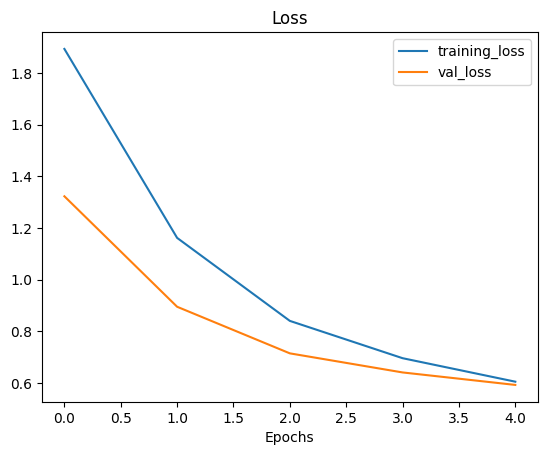

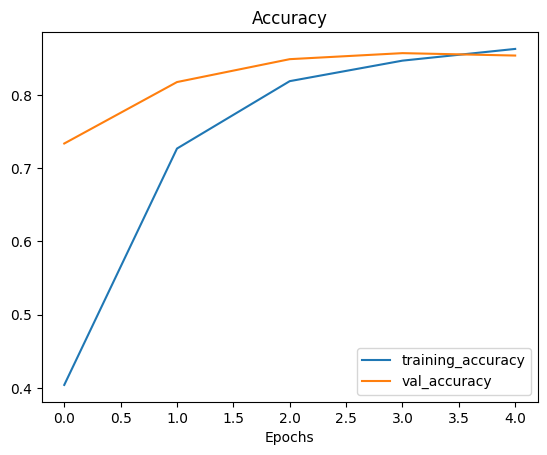

In [ ]:
# Check out our model's training curves
plot_loss_curves(history_0)

## Getting a feature vector from a trained model

Lets demonstrate the Global Average Pooling 2D layer ...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it passes through GlobalAveragePooling2D, it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [ ]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor thorough a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor: \n {global_average_pooled_tensor}\n")

# Check the shape of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [ ]:
# Lets replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis = [1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

A feature vector is **a learned representation of the input data** (a compresssed form of the input data based on how the model see's it)

**Note:** One of the reasons feature extraction transfer learning is named how it is is because what often happens is pretrained model outputs a feature vector (a long tensor of numbers which represents the learned representation of th model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can then be used to extract patterns out for our own specific problem

## Running a series of transfer learning experiments

We've see the incredible results transfer learning can get with only 10% of the training data, but how does it go with 1% of the training data ... how about we set up a bunch of experiments to find out:

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

**Note:** throughout all experiments the same test dataset will be used to evaluate our model... this ensures consistency across evaluation metrics

## Getting and preprocessing data for model one

In [4]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2023-10-14 17:14:24--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.121.207, 142.250.103.207, 108.177.120.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.121.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   221MB/s    in 0.6s    

2023-10-14 17:14:25 (221 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [5]:
# Creating training and test dirs
train_dir_1_percent = '10_food_classes_1_percent/train'
test_dir = '10_food_classes_1_percent/test'

In [6]:
# How many images are we working with ?
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There a

In [7]:
import tensorflow as tf

In [8]:
# Setup dataloaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode = 'categorical',
                                                                           image_size = IMG_SIZE,
                                                                           batch_size = BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = 'categorical',
                                                                image_size = IMG_SIZE,
                                                                batch_size = BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## Adding data augmentation right into the model

To add data augmentation right into our models, we can use the layers inside:

* `tf.keras.layers.experimental.preproecssing()`

The benefits of using data augmentation inside the model are:
* Preprocessing of images (augmenting them) happens on the GPU (much faster) rather than CPU
* Image data augmentation only happens during training, so we can still export our whole model and use it elsewhere.


In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental import preprocessing

## Create data augmentation stage with horizontal flipping, rotations, zooms, etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescale(1./255)  ## Keep for models like ResNew50V2 but EfficientNet models already have it
], name = 'data_augmentation')

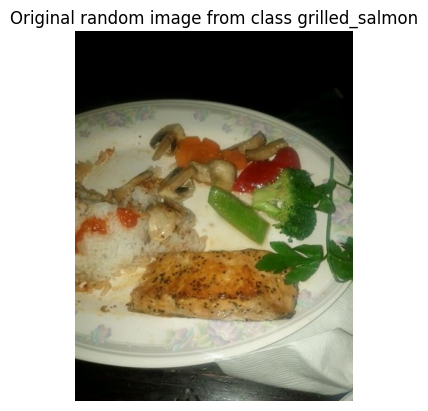

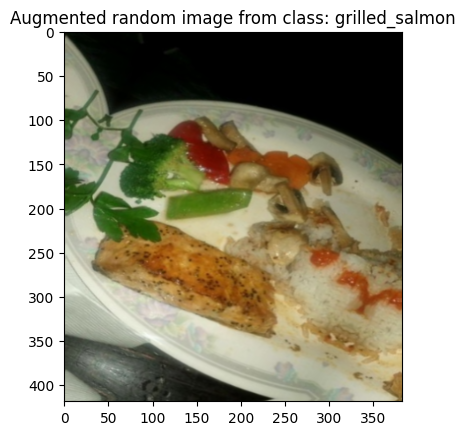

In [13]:
## View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read in the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis('off')

# Now lets plot our augmented random image
augmented_img = data_augmentation(tf.expand_dims(img, axis = 0))
plt.figure()
plt.title(f'Augmented random image from class: {target_class}')
plt.imshow(tf.squeeze(augmented_img)/255.)

### Model 1: Feature extraction transfer learning on 1% of the data with data augmentation

In [17]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top = False)
base_model.trainable = False

# Create input layer
inputs = tf.keras.layers.Input(shape = input_shape, name = 'input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model the inputs (after augmentation) and don't train it
x = base_model(x, training = False)

# Pool output features of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name = 'global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = tf.keras.layers.Dense(10, activation = 'softmax', name = 'output_layer')(x)

# Make a model using the inputs and outputs
model_1 = keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss = 'categorical_crossentropy',
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs = 5,
                                steps_per_epoch = len(train_data_1_percent),
                                validation_data = test_data,
                                validation_steps = int(0.25 * len(test_data)),
                                # Track model training logs
                                callbacks = [create_tensorboard_callback(dir_name = 'transfer_learning',
                                                                         experiment_name = '1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20231014-174047
Epoch 1/5
3/3 [==============================] - 22s 3s/step - loss: 2.4368 - accuracy: 0.1143 - val_loss: 2.2938 - val_accuracy: 0.1349
Epoch 2/5
3/3 [==============================] - 4s 1s/step - loss: 2.2283 - accuracy: 0.1857 - val_loss: 2.1868 - val_accuracy: 0.1990
Epoch 3/5
3/3 [==============================] - 4s 1s/step - loss: 2.0315 - accuracy: 0.3571 - val_loss: 2.0770 - val_accuracy: 0.2599
Epoch 4/5
3/3 [==============================] - 5s 2s/step - loss: 1.8942 - accuracy: 0.4286 - val_loss: 1.9948 - val_accuracy: 0.3503
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.7445 - accuracy: 0.5714 - val_loss: 1.8977 - val_accuracy: 0.4293


In [18]:
model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                1281

In [19]:
# Evaluate on the full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 88ms/step - loss: 1.8849 - accuracy: 0.4284


[1.8849461078643799, 0.4284000098705292]

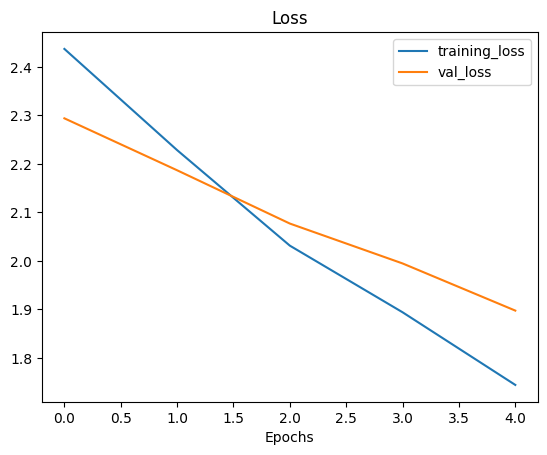

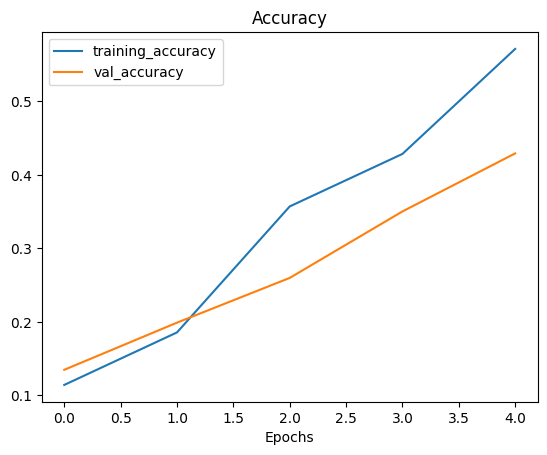

In [20]:
# Plotting loss curves
# How do the model with 1% of the data augmentation loss curves look?
plot_loss_curves(history_1_percent)